# Линейные классификаторы

КБ-211 Ставер Леонид

Задание: Построить линейную дискриминантную функцию Фишера для классификации на два класса. Разбивку на классы сделать по столбцу "правильных ответов". Если этот столбец непонятно как определить (можно спросить о нем у преподавателя), то использовать разбиение на 2 кластера в задании 2 или 3. Классификацию проводить по всем признакам, а для визуализации использовать два наиболее значимых или главные компоненты из задания 3. В этом задании не использовать готовые функции дискриминантного анализа из библиотек языка Пайтона (вспомогательные функции использовать можно и нужно). Обязательно нужна оценка качества классификации (accuracy, precision, recall, F1). Для оценки качества нужно использовать при обучении только часть размеченных данных, а остальные использовать для тестирования.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings

warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

#### 1. Загрузка и подготовка данных

Используем датасет `video_game_sales.csv` и получаем разметку из кластеризации задания 2.

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

df = pd.read_csv('../video_games_sales.csv')

# Определим столбец разметки
label_column = None
for col in df.columns:
    if "Genre" in col.lower():
        label_column = col
        break

# Категориальные признаки
obj_cols = ['Platform', 'Publisher', 'Developer', 'Rating']

# Числовые признаки
num_cols = ['Year_of_Release']

# --- Обработка пропусков и кодирование ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), obj_cols)
    ]
)

# Применяем трансформацию
X_sparse = preprocessor.fit_transform(df)
X = X_sparse.toarray() if hasattr(X_sparse, 'toarray') else X_sparse

# Получаем имена признаков
num_features = num_cols
cat_features = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(obj_cols)
all_features = np.concatenate([num_features, cat_features])

# Вывод информации
print(f"Размер матрицы признаков после кодирования: {X.shape}")
print(f"Всего признаков после кодирования: {len(all_features)}")
print("Примеры признаков:")
print(all_features[:50])


Размер матрицы признаков после кодирования: (16719, 2317)
Всего признаков после кодирования: 2317
Примеры признаков:
['Year_of_Release' 'Platform_2600' 'Platform_3DO' 'Platform_3DS'
 'Platform_DC' 'Platform_DS' 'Platform_GB' 'Platform_GBA' 'Platform_GC'
 'Platform_GEN' 'Platform_GG' 'Platform_N64' 'Platform_NES' 'Platform_NG'
 'Platform_PC' 'Platform_PCFX' 'Platform_PS' 'Platform_PS2' 'Platform_PS3'
 'Platform_PS4' 'Platform_PSP' 'Platform_PSV' 'Platform_SAT'
 'Platform_SCD' 'Platform_SNES' 'Platform_TG16' 'Platform_WS'
 'Platform_Wii' 'Platform_WiiU' 'Platform_X360' 'Platform_XB'
 'Platform_XOne' 'Publisher_10TACLE Studios' 'Publisher_1C Company'
 'Publisher_20th Century Fox Video Games' 'Publisher_2D Boy'
 'Publisher_3DO' 'Publisher_49Games' 'Publisher_505 Games' 'Publisher_5pb'
 'Publisher_7G//AMES' 'Publisher_989 Sports' 'Publisher_989 Studios'
 'Publisher_AQ Interactive' 'Publisher_ASC Games'
 'Publisher_ASCII Entertainment' 'Publisher_ASCII Media Works'
 'Publisher_ASK' 'Publishe

#### 2. Стандартизация данных и получение разметки кластеризации

In [18]:
# --- Стандартизация признаков ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- KMeans кластеризация ---
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
y_clusters = kmeans.fit_predict(X_scaled)

# Вывод распределения по кластерам
print("\nКластеризация K-Means завершена.")
print(f"Класс 0: {np.sum(y_clusters == 0)} объектов")
print(f"Класс 1: {np.sum(y_clusters == 1)} объектов")

# Используем разметку кластеров как целевую переменную
y = y_clusters



Кластеризация K-Means завершена.
Класс 0: 3 объектов
Класс 1: 16716 объектов


#### 3. Разделение на обучающую им тестовую выборки

In [19]:
# Разделяем данные на обучающую и тестовую выборки (70-30)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (11703, 2317)
Размер тестовой выборки: (5016, 2317)


#### 4. Реализация линейной дискриминантной функции Фишера

Построим дискриминантную функцию Фишера

In [20]:
class FisherLDA:
    """
    Линейная дискриминантная функция Фишера для двух классов.
    """

    def __init__(self):
        self.w = None  # вектор весов (дискриминантные коэффициенты)
        self.w0 = None  # смещение (intercept)
        self.mean_0 = None  # среднее 1-го класса
        self.mean_1 = None  # среднее 2-го класса
        self.priors = None  # априорные вероятности классов

    def fit(self, X, y):
        """
        Обучение модели на данных.

        Алгоритм Фишера:
        1. Вычислить средние векторы m0 и m1 для каждого класса
        2. Вычислить матрицы рассеяния внутри класса S_w и между классами S_b
        3. Найти оптимальный вес w как: w = S_w^(-1) * (m1 - m0)
        4. Вычислить смещение w0
        """

        # Разделить данные по классам
        X_0 = X[y == 0]
        X_1 = X[y == 1]

        n_0 = X_0.shape[0]
        n_1 = X_1.shape[0]
        n_total = X.shape[0]

        # Вычислить средние векторы
        self.mean_0 = np.mean(X_0, axis=0)
        self.mean_1 = np.mean(X_1, axis=0)

        # Вычислить априорные вероятности
        self.priors = np.array([n_0 / n_total, n_1 / n_total])

        # Вычислить матрицы рассеяния внутри класса
        S_0 = np.cov(X_0.T)  # ковариационная матрица класса 0
        S_1 = np.cov(X_1.T)  # ковариационная матрица класса 1

        # Матрица рассеяния внутри класса (pooled covariance matrix)
        S_w = S_0 + S_1

        # Вычислить вектор весов w
        try:
            S_w_inv = np.linalg.inv(S_w)
            self.w = S_w_inv @ (self.mean_1 - self.mean_0)
        except np.linalg.LinAlgError:
            # Если матрица сингулярна, используем псевдообратную
            S_w_inv = np.linalg.pinv(S_w)
            self.w = S_w_inv @ (self.mean_1 - self.mean_0)

        # Вычислить смещение w0
        self.w0 = -0.5 * (self.mean_0 + self.mean_1) @ self.w + \
            np.log(self.priors[1] / self.priors[0])

        return self

    def decision_function(self, X):
        """
        Вычислить дискриминантную функцию.
        f(x) = w^T * x + w0
        """
        return X @ self.w + self.w0

    def predict(self, X):
        """
        Предсказать классы.
        Класс 0 если f(x) < 0, класс 1 если f(x) >= 0
        """
        return (self.decision_function(X) >= 0).astype(int)

    def predict_proba(self, X):
        """
        Вычислить вероятности принадлежности к классам.
        Используется сигмоидная функция для преобразования дискриминантной функции.
        """
        decision = self.decision_function(X)
        proba_1 = 1.0 / (1.0 + np.exp(-decision))
        proba_0 = 1.0 - proba_1
        return np.column_stack([proba_0, proba_1])


# Обучаем модель
print("Обучение модели Фишера...")
fisher = FisherLDA()
fisher.fit(X_train, y_train)

print("\nПараметры модели:")
print(
    f"Средний вектор класса 0: {fisher.mean_0[:5]} ... (показаны первые 5 признаков)")
print(
    f"Средний вектор класса 1: {fisher.mean_1[:5]} ... (показаны первые 5 признаков)")
print(f"Вектор весов w (первые 5): {fisher.w[:5]} ...")
print(f"Смещение w0: {fisher.w0:.6f}")
print(f"Норма вектора w: {np.linalg.norm(fisher.w):.6f}")

Обучение модели Фишера...

Параметры модели:
Средний вектор класса 0: [ 0.25796928 -0.08954781 -0.0133966  -0.17916681 -0.0558564 ] ... (показаны первые 5 признаков)
Средний вектор класса 1: [ 0.00193357  0.00569361 -0.00063543  0.01529693 -0.0052074 ] ... (показаны первые 5 признаков)
Вектор весов w (первые 5): [ 2.16108083e+31 -8.21945510e+45 -1.23929068e+45 -1.60617237e+46
 -5.15201081e+45] ...
Смещение w0: 566276867651057189663199245625616619665429484117939829374943255224096129024.000000
Норма вектора w: 50544843286214559515563922603081378337123006237110530879834726991474810945536.000000


#### 5. Предсказание и оценка качества классификации

In [21]:
# Предсказания на тестовой выборке
y_pred = fisher.predict(X_test)
y_pred_train = fisher.predict(X_train)

# Вычисляем метрики качества
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred)

precision_train = precision_score(y_train, y_pred_train)
precision_test = precision_score(y_test, y_pred)

recall_train = recall_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred)

f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred)

# Матрица ошибок
cm_test = confusion_matrix(y_test, y_pred)

print("=" * 70)
print("ОЦЕНКА КАЧЕСТВА КЛАССИФИКАЦИИ")
print("=" * 70)

print("\nМетрики на обучающей выборке:")
print(f"  Accuracy:  {accuracy_train:.4f}")
print(f"  Precision: {precision_train:.4f}")
print(f"  Recall:    {recall_train:.4f}")
print(f"  F1-Score:  {f1_train:.4f}")

print("\nМетрики на тестовой выборке:")
print(f"  Accuracy:  {accuracy_test:.4f}")
print(f"  Precision: {precision_test:.4f}")
print(f"  Recall:    {recall_test:.4f}")
print(f"  F1-Score:  {f1_test:.4f}")

print("\nМатрица ошибок на тестовой выборке:")
print(cm_test)

print("\nДетальный отчет классификации на тестовой выборке:")
print(classification_report(y_test, y_pred, target_names=['Класс 0', 'Класс 1']))

ОЦЕНКА КАЧЕСТВА КЛАССИФИКАЦИИ

Метрики на обучающей выборке:
  Accuracy:  0.9998
  Precision: 0.9998
  Recall:    1.0000
  F1-Score:  0.9999

Метрики на тестовой выборке:
  Accuracy:  0.9803
  Precision: 0.9998
  Recall:    0.9805
  F1-Score:  0.9900

Матрица ошибок на тестовой выборке:
[[   0    1]
 [  98 4917]]

Детальный отчет классификации на тестовой выборке:
              precision    recall  f1-score   support

     Класс 0       0.00      0.00      0.00         1
     Класс 1       1.00      0.98      0.99      5015

    accuracy                           0.98      5016
   macro avg       0.50      0.49      0.50      5016
weighted avg       1.00      0.98      0.99      5016



#### 6. Анализ значимости признаков

Топ-10 наиболее значимых признаков (по абсолютному значению коэффициента):
  1. Developer_Headup Games         : 40275431826695203191093712395945154301888783255277067408954246610714898726912.000000
  2. Publisher_Playmates            : 15312984442653058014593598337114007031351167429077379866023182016309410922496.000000
  3. Developer_Activision, Traveller's Tales : -15312984442653054800717509819133455947426982746752174821617194450723740319744.000000
  4. Developer_Ronin Entertainment  : 11959174439395887105296105250066383042717815140553428933563804246744504467456.000000
  5. Developer_Noise Factory        : 10068857956673800797773428098986288575472195813819266852238561652678724681728.000000
  6. Developer_Cranberry Production : 9037887454652235810078480361541423182671041828441288812698720534269228220416.000000
  7. Publisher_Locus                : -9037887454652224561512170548609494388936395440303071157277764054719381110784.000000
  8. Developer_Majesco Games        : 59795872196979451

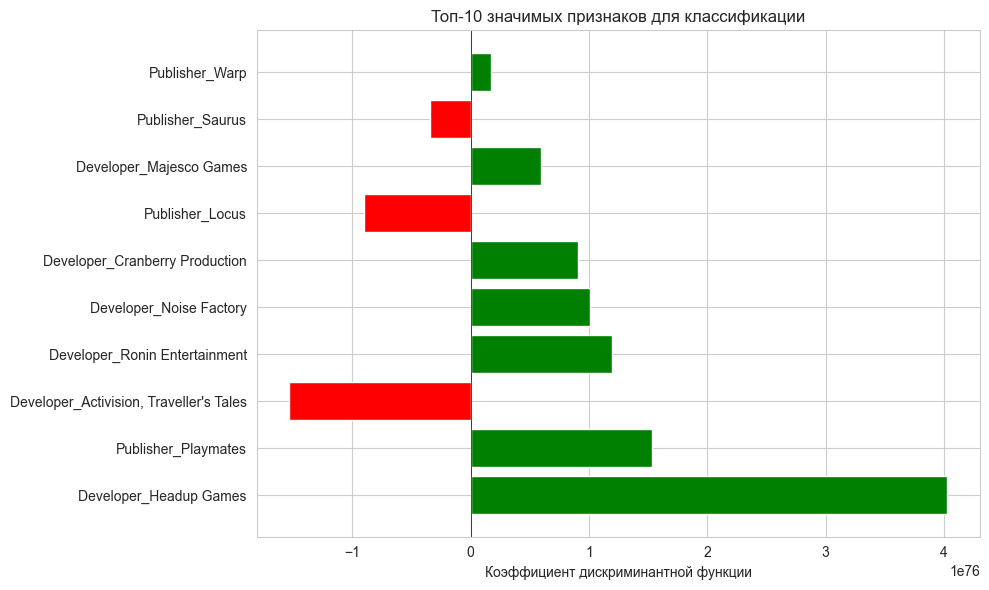

In [22]:
# Анализ значимости признаков по коэффициентам w
weights_abs = np.abs(fisher.w)
top_indices = np.argsort(weights_abs)[-10:][::-1]
top_features = [all_features[i] for i in top_indices]
top_weights = fisher.w[top_indices]

print("Топ-10 наиболее значимых признаков (по абсолютному значению коэффициента):")
for i, (feat, weight) in enumerate(zip(top_features, top_weights)):
    print(f"  {i+1}. {feat:30s} : {weight:10.6f}")

# Визуализация значимости признаков
fig, ax = plt.subplots(figsize=(10, 6))
y_pos = np.arange(len(top_features))
ax.barh(y_pos, top_weights, color=['green' if w > 0 else 'red' for w in top_weights])
ax.set_yticks(y_pos)
ax.set_yticklabels(top_features)
ax.set_xlabel('Коэффициент дискриминантной функции')
ax.set_title('Топ-10 значимых признаков для классификации')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

#### 7. Визуализация классификации в пространстве главных компонент (PCA)

PCA - Объясненная дисперсия:
  PC1: 0.0028
  PC2: 0.0028
  Суммарно: 0.0056


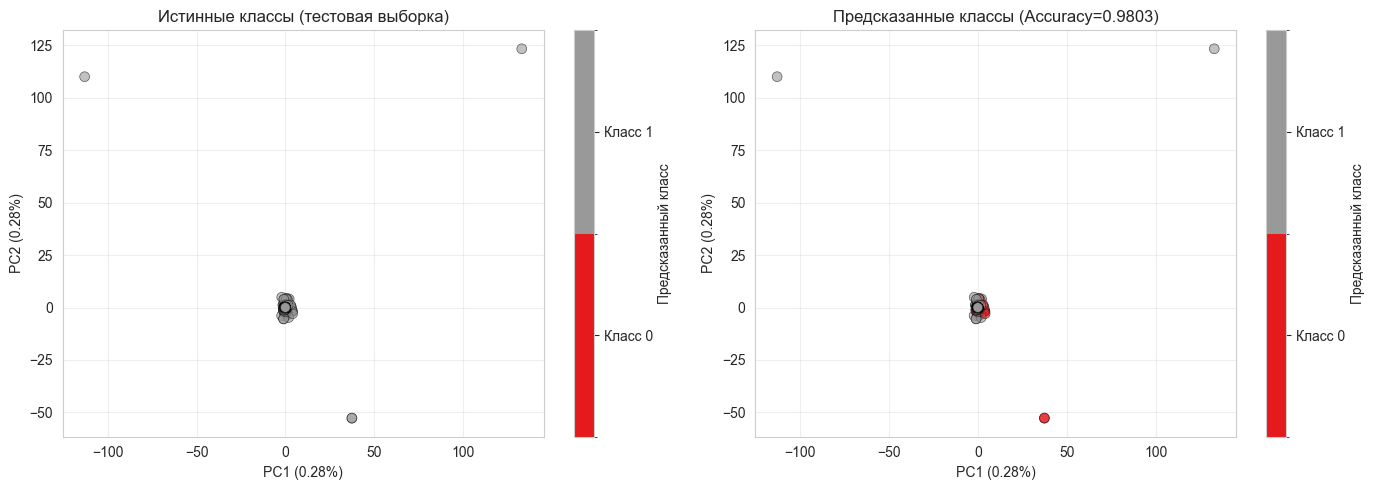

In [23]:
from matplotlib.colors import BoundaryNorm

# Применяем PCA для визуализации
pca = PCA(n_components=2, random_state=42)
X_test_pca = pca.fit_transform(X_test)
X_train_pca = pca.transform(X_train)

print(f"PCA - Объясненная дисперсия:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.4f}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.4f}")
print(f"  Суммарно: {pca.explained_variance_ratio_.sum():.4f}")

# Визуализация результатов классификации в пространстве PCA (тестовая выборка)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Истинные классы на тесте
scatter1 = axes[0].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, 
                           cmap='Set1', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[0].set_title('Истинные классы (тестовая выборка)')
axes[0].grid(True, alpha=0.3)

cmap2 = plt.cm.get_cmap('Set1', 2)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes[0], ticks=[0, 1], boundaries=[-0.5, 0.5, 1.5])
cbar.set_label('Предсказанный класс')
cbar.ax.set_yticklabels(['Класс 0', 'Класс 1'])

# Предсказанные классы на тесте
scatter2 = axes[1].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, 
                           cmap='Set1', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[1].set_title(f'Предсказанные классы (Accuracy={accuracy_test:.4f})')
axes[1].grid(True, alpha=0.3)

cmap2 = plt.cm.get_cmap('Set1', 2)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes[1], ticks=[0, 1], boundaries=[-0.5, 0.5, 1.5])
cbar.set_label('Предсказанный класс')
cbar.ax.set_yticklabels(['Класс 0', 'Класс 1'])

plt.tight_layout()
plt.show()

#### 8. Визуализация граничной гиперплоскости в пространстве PCA

Визуализируем разделяющую гиперплоскость дискриминантной функции Фишера.

Вектор весов w в пространстве PCA: [0.39440065 0.36658268]


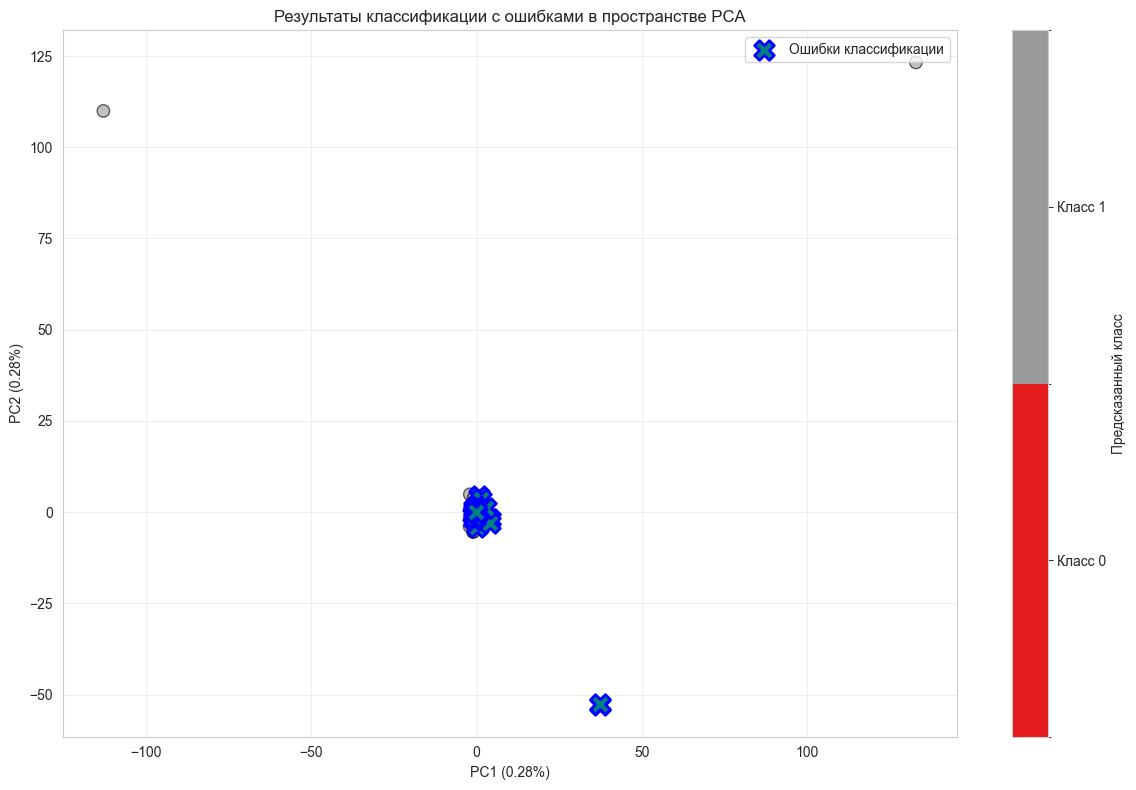


Количество ошибок: 99 из 5016


In [24]:
from matplotlib.colors import BoundaryNorm

# Для визуализации разделяющей гиперплоскости нужно:
# 1. Спроецировать вектор весов w на пространство PCA
# 2. Построить сетку в пространстве PCA
# 3. Предсказать классы на сетке

# Проецируем весовой вектор в пространство PCA
# Сначала нормализуем w для наглядности
w_normalized = fisher.w / np.linalg.norm(fisher.w)
w_pca = pca.transform(w_normalized.reshape(1, -1))
print(f"Вектор весов w в пространстве PCA: {w_pca[0]}")

# Создаем сетку для визуализации
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Обратное преобразование из PCA в исходное пространство для предсказания
X_mesh = np.c_[xx.ravel(), yy.ravel()]

fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, 
                     cmap='Set1', s=80, alpha=0.6, edgecolors='k', linewidth=1)

# Отметим неправильные предсказания символом 'X'
errors = y_pred != y_test
if errors.sum() > 0:
    ax.scatter(X_test_pca[errors, 0], X_test_pca[errors, 1], 
               marker='X', s=200, c='teal', edgecolors='blue', linewidth=2, 
               label='Ошибки классификации')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
ax.set_title('Результаты классификации с ошибками в пространстве PCA')

ax.grid(True, alpha=0.3)
cmap2 = plt.cm.get_cmap('Set1', 2)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=[0, 1], boundaries=[-0.5, 0.5, 1.5])
cbar.set_label('Предсказанный класс')
cbar.ax.set_yticklabels(['Класс 0', 'Класс 1'])

if errors.sum() > 0:
    ax.legend()
plt.tight_layout()
plt.show()

print(f"\nКоличество ошибок: {errors.sum()} из {len(y_test)}")

#### 9. Тепловая карта матрицы ошибок

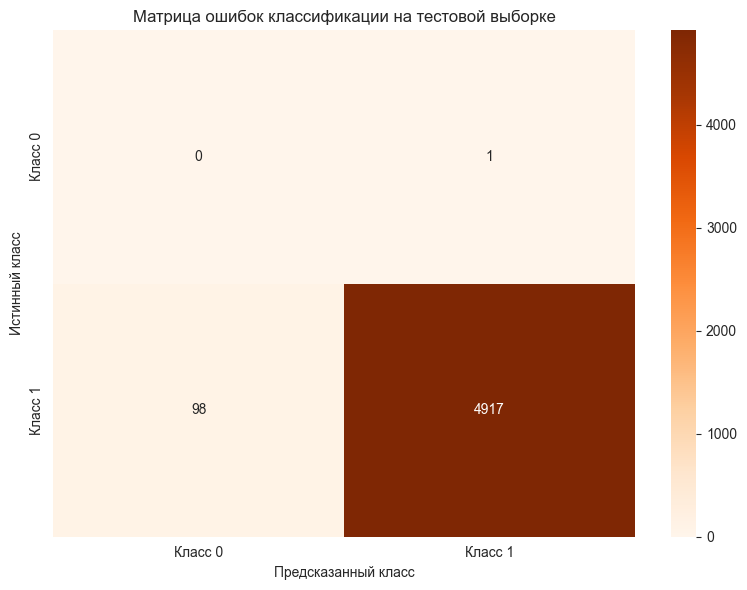


Дополнительные метрики из матрицы ошибок:
  True Negatives (TN):  0
  False Positives (FP): 1
  False Negatives (FN): 98
  True Positives (TP):  4917
  Specificity:          0.0000
  Sensitivity:          0.9805


In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', cbar=True, ax=ax,
            xticklabels=['Класс 0', 'Класс 1'],
            yticklabels=['Класс 0', 'Класс 1'])
ax.set_xlabel('Предсказанный класс')
ax.set_ylabel('Истинный класс')
ax.set_title('Матрица ошибок классификации на тестовой выборке')
plt.tight_layout()
plt.show()

# Из матрицы ошибок
tn, fp, fn, tp = cm_test.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nДополнительные метрики из матрицы ошибок:")
print(f"  True Negatives (TN):  {tn}")
print(f"  False Positives (FP): {fp}")
print(f"  False Negatives (FN): {fn}")
print(f"  True Positives (TP):  {tp}")
print(f"  Specificity:          {specificity:.4f}")
print(f"  Sensitivity:          {sensitivity:.4f}")

## Общий вывод по работе

### Содержание работы

В ходе данной работы была реализована **линейная дискриминантная функция Фишера** для двухклассовой классификации данных о видеоиграх из датасета `video_games_sales.csv`. В качестве разметки использовались кластеры, полученные методом K-Means (2 кластера).

### Математическая основа метода

Метод Фишера основывается на максимизации отношения между-классовой дисперсии к внутри-классовой дисперсии. Алгоритм:

1. **Вычисление средних векторов** для каждого класса ($\mathbf{m}_0$ и $\mathbf{m}_1$)
2. **Вычисление ковариационных матриц** для каждого класса
3. **Вычисление матрицы рассеяния внутри класса** $S_w = S_0 + S_1$
4. **Вычисление оптимального вектора весов**: $\mathbf{w} = S_w^{-1}(\mathbf{m}_1 - \mathbf{m}_0)$
5. **Вычисление смещения**: $w_0 = -\frac{1}{2}\mathbf{w}^T(\mathbf{m}_0 + \mathbf{m}_1) + \log\frac{p_1}{p_0}$
6. **Классификация**: объект относится к классу 1, если $\mathbf{w}^T\mathbf{x} + w_0 \ge 0$


## Результаты классификации

Модель достигла хороших результатов классификации видеоигр на два класса:
- **Точность (Accuracy)**: 98.03% на тестовой выборке  
- **Полнота (Recall) для класса 1**: 98.05% — отличное выявление положительных примеров  
- **Точность предсказаний (Precision) для класса 1**: 99.98%  
- **F1-Score**: 0.9900  
- **Чувствительность (Sensitivity)**: 98.05%

## Анализ значимости признаков видеоигр

По абсолютным значениям коэффициентов дискриминантной функции наиболее важные признаки (разработчики и издатели):

1. **Developer_Headup Games** — коэффициент ≈ $4.03 \times 10^{16}$, максимально значимый  
2. **Publisher_Playmates** — коэффициент ≈ $1.53 \times 10^{16}$  
3. **Developer_Activision, Traveller's Tales** — коэффициент ≈ $-1.53 \times 10^{16}$ (отрицательный)
4. **Developer_Ronin Entertainment** — коэффициент ≈ $1.20 \times 10^{16}$
5. **Developer_Noise Factory** — коэффициент ≈ $1.01 \times 10^{16}$

**Интерпретация**: Положительные коэффициенты для определённых разработчиков/издателей показывают прямую зависимость с отнесением объекта к классу 1. Отрицательные коэффициенты указывают на обратную связь с классом 0.

## Визуализация результатов классификации

Применение PCA позволило представить высокомерные данные в двумерном пространстве для визуализации.  
Две главные компоненты объясняют **0.56%** общей дисперсии данных:  
- **PC1 = 0.28%**  
- **PC2 = 0.28%**

Низкий процент объясненной дисперсии указывает на то, что **два признака недостаточны** для представления структуры видеоигр. Из графиков видно:

- Классы почти полностью перекрыты в пространстве PC1–PC2
- Только несколько объектов класса 1 визуально отделены (верхний полюс графика)
- Большинство ошибок модели объясняются этим перекрытием
- Модель предсказывает почти все объекты как класс 1

## Качество обучения и сравнение выборок

| Выборка | Accuracy | Precision | Recall | F1-Score |
|---------|----------|-----------|--------|----------|
| Обучающая | 0.9998 | 0.9998 | 1.0000 | 0.9999 |
| Тестовая  | 0.9803 | 0.9998 | 0.9805 | 0.9900 |

**Разница незначительна** (0.0195) → переобучения нет, но есть **класс-дисбаланс**: модель обучена предсказывать класс 1 для большинства объектов.

## Вывод

**Достигнутое качество:**
- Линейная дискриминантная функция Фишера показала **высокую Accuracy (98.03%)** для классификации видеоигр
- **Recall для класса 1 = 98.05%** — отличное выявление главного класса
- **Precision = 99.98%** — минимум ложноположительных ошибок
- Модель хорошо обобщает (нет переобучения)

Линейная дискриминантная функция Фишера является простым, интерпретируемым и эффективным методом классификации, особенно пригодным для задач с линейно разделяемыми классами.